In [1]:
import sys
import pandas as pd
sys.path.append("../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import importlib
import gcsfs
import math

importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

ds_101 = reload("A101")
ds_103 = reload("A103_fixed")
ds_104 = reload("A104")

# Set up dask cluster to help with computation
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39241")
client

DEBUG    17:48:27 	 ApRESDefs.py @function _setup_logging line 490 - Stream logging level set to DEBUG
DEBUG    17:48:27 	 ApRESDefs.py @function _setup_logging line 491 - Add console handler to logger
DEBUG    17:48:27 	 ApRESDefs.py @function _setup_logging line 504 - File logging level set to DEBUG


<Client: 'tcp://127.0.0.1:39241' processes=4 threads=16, memory=125.81 GiB>

In [2]:
timeseries = ds_101.isel(attenuator_setting_pair = 0,time=range(7050,7150)).compute()


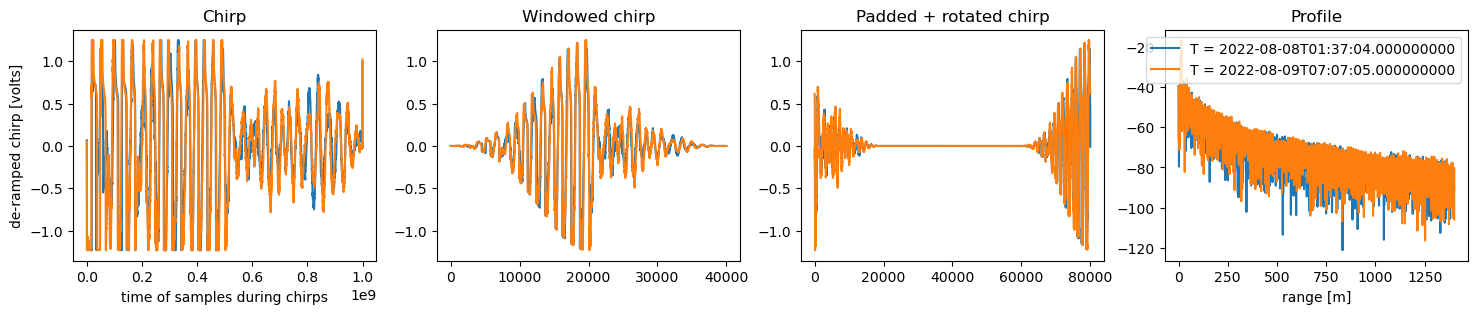

In [20]:
StartFreq = 2e8
StopFreq = 4e8
B = StopFreq - StartFreq
CentreFreq = B/2
K = 2e8 
c0 = 3e8 # speed of light in vaccuum
F0 = 2e8 # lower bound of window we want to look at in frequency space
F1 = 4e8 # upper bound of window we want to look at in frequency space
T0 = (F0-StartFreq)/K
T1 = (F1-StartFreq)/K
ER_ICE = 3.18
bin2m = c0/(2.*(T1-T0)*pad*math.sqrt(ER_ICE)*K)
fig, axs = plt.subplots(nrows = 1, ncols = 4,figsize=(18,3))

chirp1 = ds_101.isel(attenuator_setting_pair = 0,time=7062,chirp_num=0).chirp
chirp2 = ds_101.isel(attenuator_setting_pair = 0,time=7180,chirp_num=0).chirp
for example_chirp in [chirp1,chirp2]:
    example_chirp.plot(ax=axs[0])
    win_chirp = (example_chirp*np.blackman(len(example_chirp)))
    axs[1].plot(win_chirp)

    pad = 2
    Nt = len(win_chirp)
    Nfft = math.floor(Nt*pad)
    padchirp = np.zeros(Nfft)
    padchirp[0:math.floor(Nt/2)] = win_chirp.data[math.floor(Nt/2):-1]
    padchirp[-math.floor(Nt/2):] = win_chirp.data[0:math.floor(Nt/2)]
    axs[2].plot(padchirp)
    p = np.fft.fft(padchirp)/Nfft * math.sqrt(2*pad)
    profile = p[0:math.floor(Nfft/2)-1]
    m = np.asarray([i for i in range(len(profile))])/pad
    phiref = 2*math.pi*CentreFreq*m/B - m * m * 2*math.pi * K/2/B**2
    profile_ref = profile * np.exp(phiref*(-1j))
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    n = np.argmin(profile_range<=1400)
    axs[3].plot(profile_range[:n],xa.dB(profile_ref[:n]),label = f'T = {example_chirp.time.data}')
axs[0].set_title('Chirp')
axs[1].set_title('Windowed chirp')
axs[2].set_title('Padded + rotated chirp')
axs[3].set_title('Profile')
axs[3].set_xlabel('range [m]')
axs[3].legend()



    